# HW6 Social Graphs, Recommendation Systems

DATATSET MovieLens 100K Ratings https://grouplens.org/datasets/movielens/100k/

DATATSET Netflix Prize ratings Dataset https://www.kaggle.com/netflix-inc/netflix-prize-data

DATATSET Friendster Social Graph http://socialcomputing.asu.edu/datasets/Friendster

DATATSET Flicker Social Graph http://networkrepository.com/soc-Flickr-ASU.php, but use the one curated in DM resources

## PROBLEM 1 
### Recommender System using Collaborative Filtering

Implement a Movie Recommendation System and run it on the Movie Lens Dataset (Train vs Test). Mesure performance on test set using RMSE

First you are required to compute first a user-user similarity based on ratings and movies in common

Second, make rating predictions on the test set followoing the KNN idea: a prediction (user, movie) is the weighted average of other users' rating for the movie, weighted by user-similarity to the given user.

In [232]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# Split the dataset into train and test sets
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)

In [233]:
# Create user-item matrix for train and test datasets
train_matrix = train_data.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)
test_matrix = test_data.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)

# Calculate user-user similarity matrix, rows = users, cols = movies
user_similarity = cosine_similarity(train_matrix)

In [250]:
print(train_matrix.shape)
print(test_matrix.shape)
print(user_similarity.shape)

(943, 1642)
(942, 1453)
(943, 943)


In [234]:
def knn_predict(test_matrix, user_similarity, k=5):
    # Initialize prediction matrix
    pred_matrix = np.zeros(test_matrix.shape)

    # Loop through users in the test set
    for user in range(test_matrix.shape[0]):
        # Find the k most similar users
        similar_users = np.argsort(user_similarity[user])[-k:]
        
        # Calculate weighted average of the k most similar users' ratings for each movie
        for movie in range(test_matrix.shape[1]):
            pred_matrix[user, movie] = user_similarity[user, similar_users].dot(train_matrix.iloc[similar_users, movie])
            pred_matrix[user, movie] /= np.sum(np.abs(user_similarity[user, similar_users]))
    
    return pred_matrix

In [235]:
# Make predictions
predictions = knn_predict(test_matrix, user_similarity)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_matrix.values, predictions))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.8124


In [248]:
predictions[0].shape

(1453,)

## PROBLEM 3A 
### Social Community Detection

Implement edge-removal community detection algorithm on the Flicker Graph. Use the betweeness idea on edges and the Girvan–Newman Algorithm. The original dataset graph has more than 5M edges; in DM_resources there are 4 different sub-sampled graphs with edge counts from 2K to 600K; you can use these if the original is too big.

You should use a library to support graph operations (edges, vertices, paths, degrees, etc). We used igraph in python which also have builtin community detection algorithms (not allowed); these are useful as a way to evaluate communities you obtain

In [236]:
# Import libraries
import networkx as nx
from tqdm.notebook import tqdm
import igraph as ig

# Load the dataset
edges = pd.read_csv('soc-Flickr-ASU\edges_sampled_35K.csv', sep=',', names=['node1', 'node2'], dtype=int)

# Create a graph from the dataset
G = nx.from_pandas_edgelist(edges, 'node1', 'node2')

In [240]:
def bfs_shortest_paths(G, source):
    S = []
    P = {}
    sigma = dict.fromkeys(G.nodes(), 0)
    sigma[source] = 1
    dist = dict.fromkeys(G.nodes(), None)
    dist[source] = 0
    Q = [source]

    while Q:
        v = Q.pop(0)
        S.append(v)

        for w in G.neighbors(v):
            # Path discovery
            if dist[w] is None:
                Q.append(w)
                dist[w] = dist[v] + 1
                
            # Path counting
            if dist[w] == dist[v] + 1:
                sigma[w] += sigma[v]
                P[w] = P.get(w, []) + [v]
                
    return S, P, sigma

def modularity(G, communities):
    m = G.number_of_edges()
    degrees = dict(G.degree())
    modularity_score = 0

    for community in communities:
        L_c = sum(G.has_edge(u, v) for u in community for v in community)
        k_c = sum(degrees[u] for u in community)
        modularity_score += L_c / m - (k_c / (2 * m)) ** 2

    return modularity_score


def edge_betweenness(G):
    betweenness = {(u, v): 0 for u, v in G.edges()}
    for s in tqdm(G.nodes(), desc="Computing edge betweenness", leave=False):
        S, P, sigma = bfs_shortest_paths(G, s)
        for t in G.nodes():
            if t != s:
                p_list = find_all_paths(P, s, t)
                coeff = sum(sigma[s] / sigma[p] for p in p_list)
                for p in p_list:
                    betweenness[(p, s)] += coeff / 2 if p < s else 0

    return betweenness

def find_all_paths(P, start, end, path=[]):
    path = path + [start]
    if start == end:
        return [path]
    if start not in P:
        return []
    paths = []
    for node in P[start]:
        if node not in path:
            new_paths = find_all_paths(P, node, end, path)
            paths.extend(new_paths)
    return paths


In [238]:
edge_betw = edge_betweenness(G)


Computing edge betweenness:   0%|          | 0/4398 [00:00<?, ?it/s]

In [241]:
def girvan_newman(G, max_iter=None):
    G_copy = G.copy()
    max_modularity = -1
    best_partition = None
    iteration = 0

    while G_copy.edges():
        edge_betw = edge_betweenness(G_copy)
        max_betw = max(edge_betw.values())
        edges_to_remove = [e for e, betw in edge_betw.items() if betw == max_betw]

        G_copy.remove_edges_from(edges_to_remove)
        communities = list(nx.connected_components(G_copy))

        current_modularity = modularity(G, communities)
        
        if current_modularity > max_modularity:
            max_modularity = current_modularity
            best_partition = communities
        else:
            # Modularity not increasing, stop the algorithm
            break

        iteration += 1
        if max_iter and iteration >= max_iter:
            # Maximum number of iterations reached
            break

    return best_partition

# Run the modified Girvan-Newman algorithm
communities = girvan_newman(G)

Computing edge betweenness:   0%|          | 0/4398 [00:00<?, ?it/s]

C:\Users\chase\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


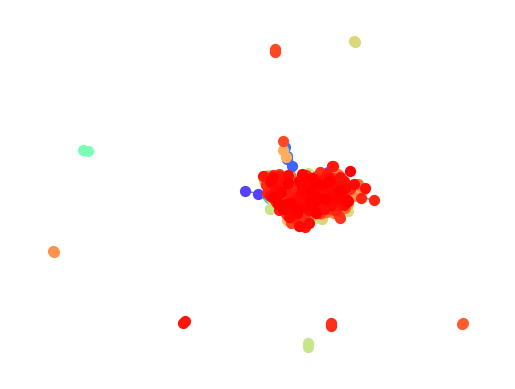

In [242]:
import matplotlib.pyplot as plt
import networkx as nx

pos = nx.spring_layout(G, seed=42)  # Compute node positions using the spring layout algorithm
colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))

for idx, community in enumerate(communities):
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=community,
        node_color=colors[idx],
        node_size=50,
    )

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.axis("off")
plt.show()


In [243]:
import networkx as nx
import infomap

def networkx_to_infomap(G):
    im = infomap.Infomap("--two-level")
    for e in G.edges():
        im.add_link(*e)
    return im

def infomap_communities(im):
    im.run()
    communities = {}
    for node in im.nodes:
        if node.is_leaf:
            if node.module_id not in communities:
                communities[node.module_id] = []
            communities[node.module_id].append(node.node_id)
    return list(communities.values())

# Convert NetworkX graph to Infomap
G_infomap = networkx_to_infomap(G)

# Run Infomap algorithm
infomap_communities = infomap_communities(G_infomap)

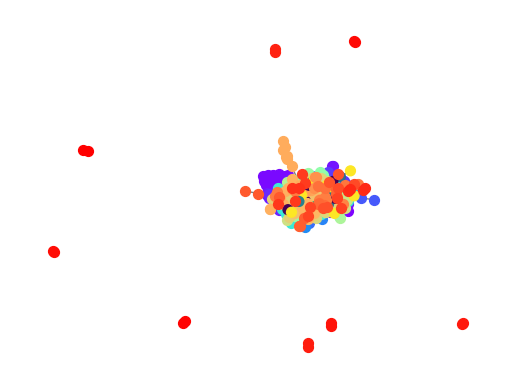

In [244]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, seed=42)  # Compute node positions using the spring layout algorithm
colors = plt.cm.rainbow(np.linspace(0, 1, len(infomap_communities)))

for idx, community in enumerate(infomap_communities):
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=community,
        node_color=colors[idx],
        node_size=50,
    )

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.axis("off")
plt.show()


I got fairly similar looking communities when comparing the girvan newman algorithm I created to the community detection in igraph

## PROBLEM 4
### Knowledge Base Question Answering

Given is knowledge graph with entities and relations, questions with starting entity and answers, and their word embedding . 

For each question, navigate the graph from the start entity outwards until you find appropriate answer entities.

- there might be multiple answers correct, use F1 to evaluate

- utils functions (similarity, load_graphs) are given, but you can choose not to use them

- answers are given to be used for evaluation only

- your strategy should be a graph traversal augmented with scoring of paths; you might discard paths not promising along the way. This is similar to a focused crawl strategy.

- for simplicity, the questions are picked so that the answer is always at the end of the relevant path (not intermediary)

In [200]:
import gensim
import numpy as np
from collections import defaultdict, deque
from nltk import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from queue import PriorityQueue

RELATION_THRESHOLD = 0.3

# Load Word2Vec model
word2vec_model = gensim.models.Word2Vec.load('word2vec_train+dev')


def get_rel_score_word2vecbase(rel, query):
    if rel not in word2vec_model.wv:
        return 0.0
    words = word_tokenize(query.lower())
    word_embeddings = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(cosine_similarity(word_embeddings, [word2vec_model.wv[rel]]))


def load_graph():
    graph = defaultdict(list)
    for line in open('graph'):
        line = eval(line[:-1])
        graph[line[0]].append([line[1], line[2]])
    return graph


def load_queries():
    queries = []
    for line in open('annotations'):
        line = eval(line[:-1])
        queries.append(line)
    return queries


def bfs(graph, start, question):
    visited, queue, paths = set(), PriorityQueue(), []
    queue.put((-1, start, [start]))

    while not queue.empty():
        priority, node, path = queue.get()

        if node not in visited:
            visited.add(node)

            if is_entity(node):
                paths.append({'AnswerType': 'Entity', 'AnswerArgument': node, 'EntityName': ' '.join(path), 'RelationScore': -priority})

            for rel, neighbor in graph[node]:
                if neighbor not in visited:
                    rel_score = get_rel_score_word2vecbase("ns:" + rel, question)
                    if rel_score >= RELATION_THRESHOLD:
                        queue.put((-rel_score, neighbor, path + [neighbor]))

    return paths


def evaluate(pred, gold):
    pred = set((item['AnswerType'], item['AnswerArgument']) for item in pred)
    gold = set((item['AnswerType'], item['AnswerArgument']) for item in gold)

    tp = len(pred.intersection(gold))
    fp = len(pred - gold)
    fn = len(gold - pred)

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1


def is_entity(s):
    return s.startswith('m.')

def main():
    graph = load_graph()
    queries = load_queries()

    total_precision = 0
    total_recall = 0
    total_f1 = 0

    for i, query in enumerate(queries):
        _, question, start, temp, _, answers = query
        temp = temp[0][1]

        predictions = bfs(graph, start, question)
        filtered_predictions = [p for p in predictions if p['AnswerType'] == 'Entity']

        precision, recall, f1 = evaluate(filtered_predictions, answers)

        rel = temp
        #print("Relationship scores for gold entities:")
        for gold_entity in answers:
            rel_name = gold_entity['EntityName']
            rel_score = get_rel_score_word2vecbase(rel, question)
            #print(f"{gold_entity['AnswerArgument']} ({rel_name}): {rel_score}")

        total_precision += precision
        total_recall += recall
        total_f1 += f1

        print(f'Query {i}: {question}')
        pred_str = ', '.join([p['AnswerArgument'] for p in predictions])
        print(f'Predicted: [{pred_str}]')
        gold_str = ', '.join([f"{a['AnswerArgument']} ({a['EntityName']})" for a in answers])
        print(f'Gold: [{gold_str}]')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1: {f1:.2f}\n')

    avg_precision = total_precision / len(queries)
    avg_recall = total_recall / len(queries)
    avg_f1 = total_f1 / len(queries)

    print(f'Average Precision: {avg_precision:.2f}')
    print(f'Average Recall: {avg_recall:.2f}')
    print(f'Average F1: {avg_f1:.2f}')


if __name__ == '__main__':
    main()


Query 0: what time zones are there in the us
Predicted: [m.09c7w0, m.027wj2_, m.027wjl3, m.02fqwt, m.02hcv8, m.02hczc, m.02lcqs, m.02lcrv, m.02lctm, m.042g7t]
Gold: [m.027wj2_ (Samoa Time Zone), m.027wjl3 (Chamorro Time Zone), m.02fqwt (Central Time Zone), m.02hcv8 (Eastern Time Zone), m.02hczc (Mountain Time Zone), m.02lcqs (Pacific Time Zone), m.02lcrv (Alaska Time Zone), m.02lctm (Hawaii-Aleutian Time Zone), m.042g7t (Atlantic Time Zone)]
Precision: 0.90
Recall: 1.00
F1: 0.95

Query 1: what are major exports of the usa
Predicted: [m.09c7w0, m.04g4s8k, m.04g4s8q, m.04g4s8w, m.04g4s90, m.015smg, m.03q9wp2, m.03qtd_n, m.03qtf10]
Gold: [m.015smg (Automotive industry), m.03q9wp2 (Food Manufacturing), m.03qtd_n (Pharmaceutical Preparation), m.03qtf10 (Industrial Organic Chemicals, NEC)]
Precision: 0.44
Recall: 1.00
F1: 0.62

Query 2: what time is right now in texas
Predicted: [m.07b_l, m.02fqwt, m.02hczc, m.09c7w0, m.027wj2_, m.027wjl3, m.02hcv8, m.02lcqs, m.02lcrv, m.02lctm, m.042g7t]
Go

Query 19: where is south carolina located
Predicted: [m.06yxd, m.09c7w0, m.0fv_t, m.01_6pxw, m.01_d4, m.03v0t, m.01_6p6k, m.01_6p8l, m.01_6p9s, m.01_6p_k, m.01_6pdj, m.01_6pgd, m.01_6ph7, m.01_6pmb, m.01_6pnb, m.01_6pp5, m.01_6ps8, m.01_6pvy, m.01_6q0k, m.01_6q1q, m.01_6q8p, m.01_6q9q, m.01_6qcm, m.01_6qjr, m.01_6qp4, m.01_6qrp, m.01_6qsj, m.01_6qz6, m.01_6r1z, m.01_6r78, m.01_6r82, m.01_6rf1, m.01_6rfw, m.01_6s0l, m.01_6s_6, m.01_6smy, m.01_6sws, m.01_6t1b, m.01_6t43, m.01_6t4y, m.01_6t5r, m.01_6t95, m.01_6tgy, m.01_6v4j, m.01_6v6w, m.01_6y3n, m.01_6zk1, m.01_7140, m.01_71cx, m.01_72xz, m.01_73_n, m.01_75zb, m.01_77qt, m.01_77x6, m.01_78lh, m.01_78nm, m.01_78wb, m.01_795b, m.01_7gfz, m.03dpqpb, m.03dpqrm, m.065rklh, m.07nqmf7, m.07nqmfg, m.07nqmfp, m.07nqmfx, m.07nqmg3, m.07nqmg_, m.07nqmgb, m.07nqmgk, m.07nqmgs, m.07nqmh6, m.07nqmhf, m.07nqmhn, m.07nqmhw, m.07nqmj2, m.07nqmj9, m.07nqmjj, m.07nqmjr, m.07nqmjz, m.07nqmk5, m.07nqmkd, m.07nqmkm, m.07nqmkv, m.07nqml1, m.07nqml8, m.07nqmlh

Query 28: what timezone is the state of texas
Predicted: [m.07b_l, m.02fqwt, m.02hczc, m.09c7w0, m.027wj2_, m.027wjl3, m.02hcv8, m.02lcqs, m.02lcrv, m.02lctm, m.042g7t, m.01_d4, m.03v0t, m.01dlzc, m.021czc, m.059g4, m.06yxd, m.0fv_t, m.0mmyl, m.0vzm, m.01_6p6k, m.01_6p8l, m.01_6p9s, m.01_6p_k, m.01_6pdj, m.01_6pgd, m.01_6ph7, m.01_6pmb, m.01_6pnb, m.01_6pp5, m.01_6ps8, m.01_6pvy, m.01_6pxw, m.01_6q0k, m.01_6q1q, m.01_6q8p, m.01_6q9q, m.01_6qcm, m.01_6qjr, m.01_6qp4, m.01_6qrp, m.01_6qsj, m.01_6qz6, m.01_6r1z, m.01_6r78, m.01_6r82, m.01_6rf1, m.01_6rfw, m.01_6s0l, m.01_6s_6, m.01_6smy, m.01_6sws, m.01_6t1b, m.01_6t43, m.01_6t4y, m.01_6t5r, m.01_6t95, m.01_6tgy, m.01_6v4j, m.01_6v6w, m.01_6y3n, m.01_6zk1, m.01_7140, m.01_71cx, m.01_72xz, m.01_73_n, m.01_75zb, m.01_77qt, m.01_77x6, m.01_78lh, m.01_78nm, m.01_78wb, m.01_795b, m.01_7gfz, m.03dpqpb, m.03dpqrm, m.065rklh, m.07nqmf7, m.07nqmfg, m.07nqmfp, m.07nqmfx, m.07nqmg3, m.07nqmg_, m.07nqmgb, m.07nqmgk, m.07nqmgs, m.07nqmh6, m.07nqmhf, m

Query 45: what school did michael jackson attend
Predicted: [m.09889g, m.0n1cs5l, m.06lhpy]
Gold: [m.06lhpy (Montclair College Preparatory School)]
Precision: 0.33
Recall: 1.00
F1: 0.50

Query 46: what was the cause of death of michael jackson
Predicted: [m.09889g, m.0gg4h, m.010klcpt, m.012mtk5b, m.0132tgw6, m.01hl2j6, m.01hl3jm, m.01hl3t4, m.01hl40t, m.01hl444, m.01hl45_, m.01hl48b, m.01hl4hb, m.01hl4l8, m.01k9bm5, m.01n7xgt, m.02srz6, m.02st0w, m.02st1p, m.03jg4tt, m.03jgszc, m.047qwf7, m.06308p, m.06_y1fq, m.06w81qp, m.096y7s, m.0g6_q__, m.0jwt60n, m.0q8flcq, m.0vypv96, m.0w508xx, m.0y4qyrn]
Gold: [m.0gg4h (Cardiac arrest)]
Precision: 0.03
Recall: 1.00
F1: 0.06

Query 47: what is the capital city of texas usa
Predicted: [m.07b_l, m.09c7w0, m.0vzm]
Gold: [m.0vzm (Austin)]
Precision: 0.33
Recall: 1.00
F1: 0.50

Query 48: who influenced michael jackson
Predicted: [m.09889g, m.01b9db, m.01lc5, m.0407f, m.04ct6p, m.081nh, m.0652zr5, m.0652zrb, m.09kkmyf, m.09kkmyr, m.0nf3l7x, m.01zmpg, 